# Creating dataset

In [1]:
from tensorflow.keras.preprocessing.image import load_img,save_img,img_to_array,array_to_img,ImageDataGenerator
from numpy import expand_dims,asarray,savez_compressed,load,unique
import os
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.models import load_model

In [2]:
detector = MTCNN()

In [3]:
def extract_face(image):
    required_size=(160, 160)
    faces = detector.detect_faces(image)
    (x, y, w, h)  = faces[0]['box']
    x_inc = int(w*0.2)
    y_inc = int(h*0.2)
    face = image[y-y_inc:y+h+y_inc, x-x_inc:x+w+x_inc]
    face = array_to_img(face)
    face = face.resize(required_size)
    face_array = img_to_array(face)
    return face_array

In [4]:
def load_dataset(path):
    images=[]
    labels=[]
    datagen=ImageDataGenerator(rotation_range=50,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.1,
                               brightness_range=(0.2,0.7))

    inames=os.listdir(path)
    for iname in inames:
        img=load_img(path+"/"+iname)
        img=img_to_array(img)
        face=extract_face(img)
        face = expand_dims(face, 0)

        it = datagen.flow(face, batch_size=1)
        for i in range(20):
            batch = it.next()
            image = batch[0].astype('uint8')
            #save_img("Aug/"+iname[0:11]+"_"+str(i)+".jpg",image)
            images.append(image)
            labels.append(iname[0:9])
        
    return asarray(images),asarray(labels)

In [5]:
trainX, trainy = load_dataset("dataset/train")
print(trainX.shape, trainy.shape)


(800, 160, 160, 3) (800,)


In [6]:
labels=unique(trainy)
savez_compressed('dataset/reg_nums.npz',labels)
print(labels)

['Y15ACS497' 'Y16ACS547' 'Y17ACS517' 'Y17ACS520' 'Y17ACS521' 'Y17ACS530'
 'Y17ACS531' 'Y17ACS534' 'Y17ACS536' 'Y17ACS537' 'Y17ACS539' 'Y17ACS540'
 'Y17ACS544' 'Y17ACS550' 'Y17ACS557' 'Y17ACS559' 'Y17ACS562' 'Y17ACS563'
 'Y17ACS565' 'Y17ACS569']


# Extract Face embedings (FaceNet)

In [7]:
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples)
    return yhat[0]

In [8]:
face_model = load_model('models/facenet_keras.h5')

In [9]:
face_model.summary()

_________________
Block8_1_Branch_1_Conv2d_0b_1x3 (None, 3, 3, 192)    0           Block8_1_Branch_1_Conv2d_0b_1x3_B
__________________________________________________________________________________________________
Block8_1_Branch_0_Conv2d_1x1 (C (None, 3, 3, 192)    344064      Mixed_7a[0][0]                   
__________________________________________________________________________________________________
Block8_1_Branch_1_Conv2d_0c_3x1 (None, 3, 3, 192)    110592      Block8_1_Branch_1_Conv2d_0b_1x3_A
__________________________________________________________________________________________________
Block8_1_Branch_0_Conv2d_1x1_Ba (None, 3, 3, 192)    576         Block8_1_Branch_0_Conv2d_1x1[0][0
__________________________________________________________________________________________________
Block8_1_Branch_1_Conv2d_0c_3x1 (None, 3, 3, 192)    576         Block8_1_Branch_1_Conv2d_0c_3x1[0
___________________________________________________________________________________________

In [10]:
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(face_model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

savez_compressed('dataset/student_face_embeddings.npz', newTrainX, trainy)

(800, 128)


# Training

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import numpy as np
import pickle

In [12]:
data = load('dataset/student_face_embeddings.npz')
trainX, trainy = data['arr_0'], data['arr_1']

In [13]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)


In [14]:
# fit model
model = SVC(kernel='poly', probability=True)
model.fit(trainX, trainy)

SVC(kernel='poly', probability=True)

In [15]:
yhat_train = model.predict(trainX)
# score
score_train = accuracy_score(trainy, yhat_train)
# summarize
print('Accuracy: train=%.3f' % (score_train*100))

Accuracy: train=100.000


In [16]:
pickle.dump(model, open('models/predicition_model.h5', 'wb'))

# Testing

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2

In [18]:
filename = 'dataset/test/group.jpg'
image = load_img(filename)
image=img_to_array(image)

detector = MTCNN()
faces = detector.detect_faces(image)
facemodel=load_model('models/facenet_keras.h5')

faceembedings=[]
facelocations=[]
for face in faces:
    x, y, w, h = face['box']
    facelocations.append((x,y,x + w,y + h))
    student=image[y:y + h,x:x + w,]
    student=cv2.resize(student,(160,160))
    faceembd=get_embedding(facemodel,student)
    faceembedings.append(faceembd)
faceembedings=asarray(faceembedings)

In [19]:
model=pickle.load(open('models/predicition_model.h5', 'rb'))

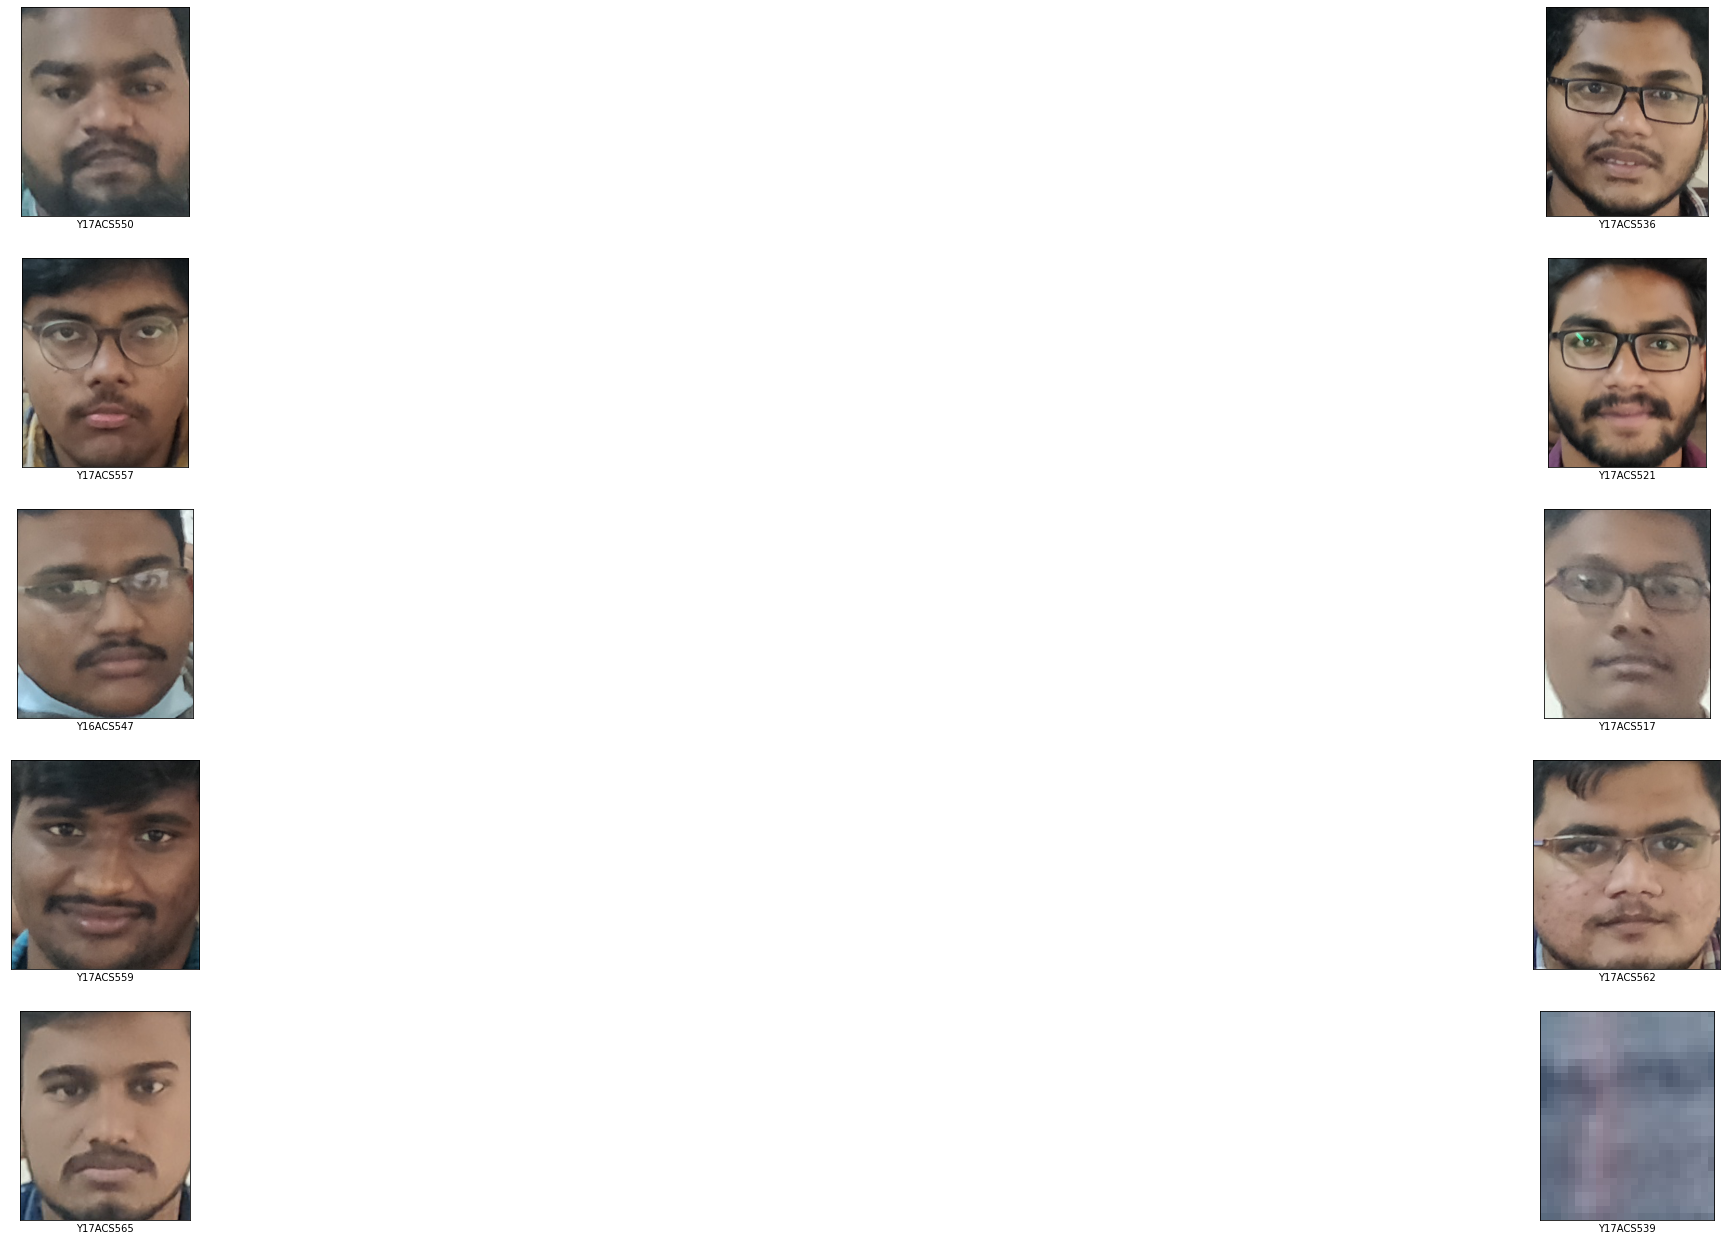

In [20]:
plt.figure(figsize=(50,50))
t=0
for i in range(len(facelocations)):
    t+=1
    x,y,a,b=facelocations[i]
    name=labels[model.predict(faceembedings[i:i+1])[0]]
    plt.subplot(11,2,t)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[y:b,x:a,].astype('uint8'))
    plt.xlabel(name)
                
    